In [10]:
import os
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

In [11]:
#######################################################################################################
#Load saved model
#######################################################################################################
os.chdir(r'I:\SLIOT-backend\modelsave')
ts_model=load_model(os.path.join(os.getcwd(), "lstm_model.h5"))
ts_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 1, 128)            434688    
                                                                 
 dropout_24 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_25 (LSTM)              (None, 1, 128)            131584    
                                                                 
 dropout_25 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_26 (LSTM)              (None, 1, 128)            131584    
                                                                 
 dropout_26 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_27 (LSTM)              (None, 128)              

In [12]:
#######################################################################################################
np.random.seed(1)
#Load the sequence data from csv
df = pd.read_csv('I:\SLIOT-backend\originaldataset\AEP_hourly.csv')
requests = pd.DataFrame(data=df,columns=['AEP_MW'])
#if any missing value fill it by previous value and convert all requests into integer type
requests.ffill(inplace=True)
requests["AEP_MW"]=requests["AEP_MW"].astype(float).astype(int)
##############################################################################################################
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)

In [13]:
#############################################################################
#scale the data
print("Request Range before scaling:",min(requests.AEP_MW),max(requests.AEP_MW))
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
print("Request Range after scaling:",min(scaled_requests),max(scaled_requests))

#Traing data has to be sequential
train_size = int(len(df)*0.9)
test_size =len(df)-train_size

#Number of samples to lookback for each sample
#720 default
lookback =720

#sperate training and test data
train_data = scaled_requests[0:train_size,:]

#Add an additional week for lookback
test_data = scaled_requests[train_size:len(df),:1]

print("\n Shaped of Train ,Test :", train_data.shape ,test_data.shape)


Request Range before scaling: 9581 25695
Request Range after scaling: [-2.28391613] [3.93437215]

 Shaped of Train ,Test : (90954, 1) (30319, 1)


In [14]:
#####################################################################################################
#pepare RNN Dataset
def create_rnn_dataset(data, lookback=1):
  
  data_x,data_y = [],[]
  for i in range(len(data)- lookback -1):
    a = data[i:(i + lookback),0]
    data_x.append(a)
    data_y.append(data[i + lookback,0])
  return np.array(data_x),np.array(data_y)

#create x and y for training
x_train , y_train = create_rnn_dataset(train_data , lookback)

#Reshape for use with LSTM
x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))

print("shapes of x,y:",x_train.shape , y_train.shape)
##############################################################################
#Preprocess
x_test , y_test =create_rnn_dataset(test_data , lookback)
x_test = np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))
ts_model.evaluate(x_test , y_test, verbose=1)

#predict for the training dataset
predict_on_train = ts_model.predict(x_train)
#Prdeict on the test dataset
predict_on_test = ts_model.predict(x_test)

#train_mae_loss = np.mean(np.abs(predict_on_train - x_train), axis=1)

shapes of x,y: (90233, 1, 720) (90233,)
925/925 [==============================] - 4s 4ms/step


In [15]:



##########################################################################

from sklearn.metrics import r2_score
score = r2_score(y_test, predict_on_test)
print("The accuracy of our model is {}%".format(round(score, 2) *100))
######################################################################
from sklearn import metrics
import os
score = np.sqrt(metrics.mean_squared_error(y_test,predict_on_test))
print(f'After training the RMSE is:{score}')
#######################################################################
# trainMAE = np.mean(np.abs(predict_on_train - x_train), axis=1)
# testMAE = np.mean(np.abs(predict_on_test - x_test), axis=1)
# print(f'After training the MAE is:{testMAE}')
# #########################################################################
# plt.hist(testMAE , bins=50)
# plt.xlabel('Test MAE loss')
# plt.ylabel('Number of samples')
################################################################################

################################################################################
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)
##############################################################################

The accuracy of our model is 98.0%
After training the RMSE is:0.12208310937346611


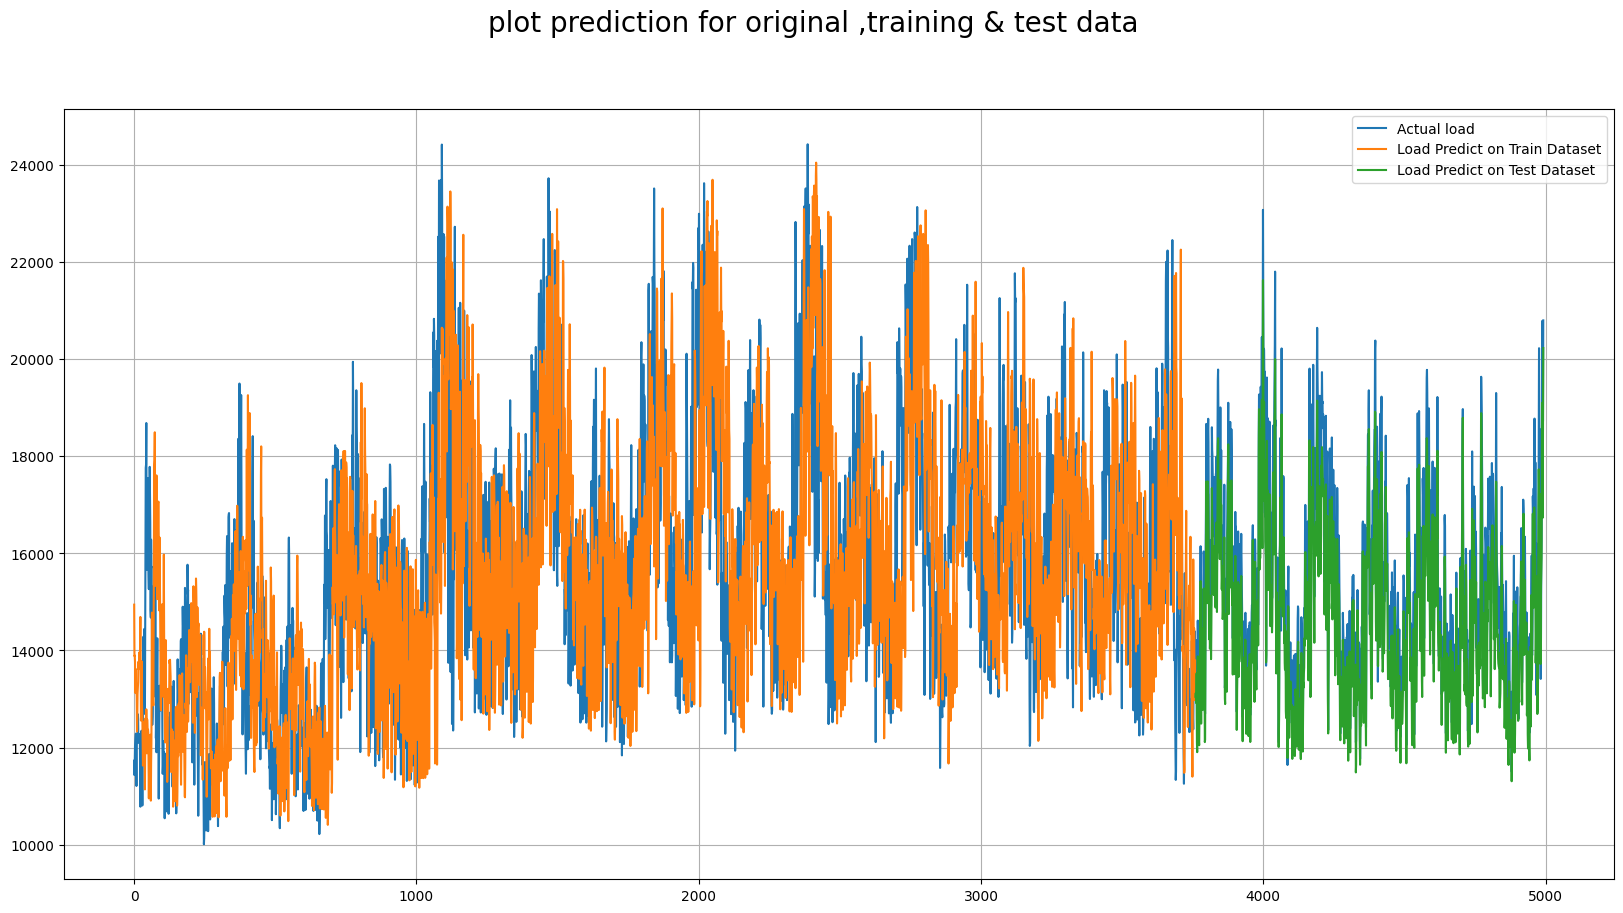

In [16]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train)+ len(predict_on_test)

#plot original data 
orig_data =requests.AEP_MW.to_numpy()
orig_data = orig_data.reshape(len(orig_data),1)

#cretae a plot for original data
orig_plot = np.empty((total_size , 1))
orig_plot[:,:] = np.nan
orig_plot[0:total_size,:]= orig_data[lookback*2:-2,]

#Create a plot for prediction on training
predict_train_plot =np.empty((total_size , 1))
predict_train_plot[:,:] = np.nan
predict_train_plot[0:len(predict_on_train),:] = predict_on_train

#Create a plot for prediction on testing
predict_test_plot =np.empty((total_size , 1))
predict_test_plot[:,:] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test),:]=predict_on_test

#plot the graphs
plt.figure(figsize=(20,10)).suptitle("plot prediction for original ,training & test data", fontsize=20)
plt.plot(orig_plot[::24], label='Actual load')
plt.plot(predict_train_plot[::24], label='Load Predict on Train Dataset')
plt.plot(predict_test_plot[::24], label='Load Predict on Test Dataset')
# Function add a legend
plt.legend()
plt.grid()
plt.show()
df1 = pd.DataFrame(orig_plot[::24], columns = ['original_AEP_MW'])

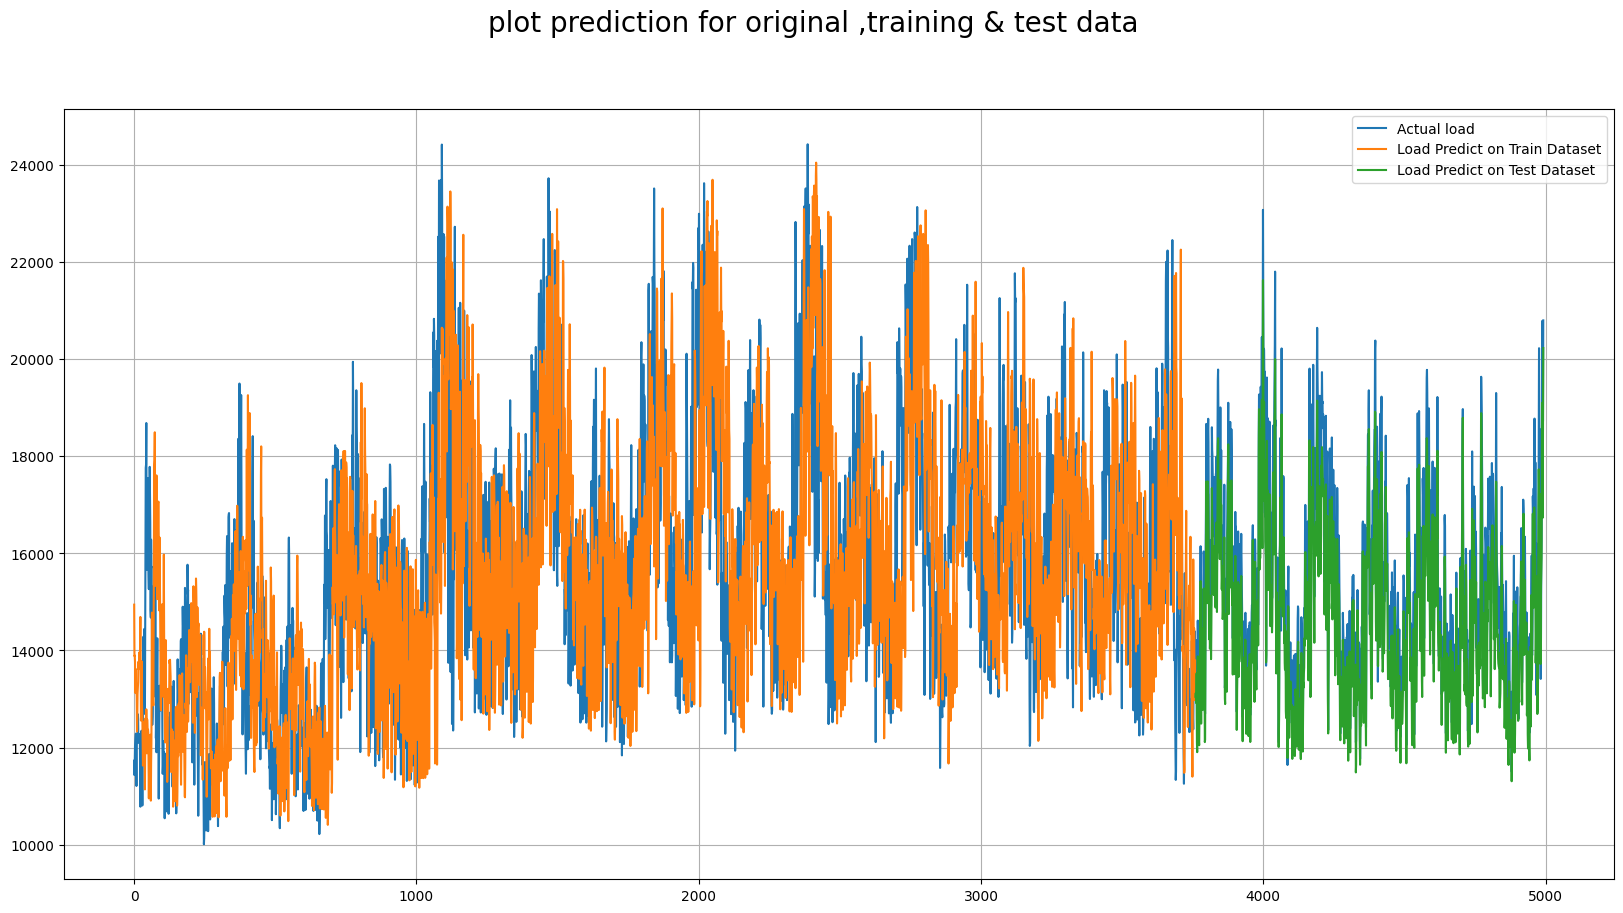

In [17]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train)+ len(predict_on_test)

#plot original data 
orig_data =requests.AEP_MW.to_numpy()
orig_data = orig_data.reshape(len(orig_data),1)

#cretae a plot for original data
orig_plot = np.empty((total_size , 1))
orig_plot[:,:] = np.nan
orig_plot[0:total_size,:]= orig_data[lookback*2:-2,]

#Create a plot for prediction on training
predict_train_plot =np.empty((total_size , 1))
predict_train_plot[:,:] = np.nan
predict_train_plot[0:len(predict_on_train),:] = predict_on_train

#Create a plot for prediction on testing
predict_test_plot =np.empty((total_size , 1))
predict_test_plot[:,:] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test),:]=predict_on_test

#plot the graphs
plt.figure(figsize=(20,10)).suptitle("plot prediction for original ,training & test data", fontsize=20)
plt.plot(orig_plot[::24], label='Actual load')
plt.plot(predict_train_plot[::24], label='Load Predict on Train Dataset')
plt.plot(predict_test_plot[::24], label='Load Predict on Test Dataset')
# Function add a legend
plt.legend()
plt.grid()
plt.show()

df1 = pd.DataFrame(orig_plot[0:total_size,:], columns = ['original_AEP_MW'])
# Convert DataFrame to JSON
data = df1.to_json('I:\SLIOT-backend\outputs\original_AEP_MW_export.json', orient='records')

df2 = pd.DataFrame(predict_train_plot[0:len(predict_on_train),:], columns = ['PredictedMeagWatt1'])
# Convert DataFrame to JSON
data = df2.to_json('I:\SLIOT-backend\outputs\predict_train_AEP_MW_export.json', orient='records')

df3 = pd.DataFrame(predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test),:], columns = ['PredictedMeagWatt2'])
# Convert DataFrame to JSON
data = df3.to_json('I:\SLIOT-backend\outputs\predict_test_AEP_MW_export.json', orient='records')
#print(df1.head(6))
predict_train_test_result = pd.concat([df2, df3], axis=1)
data = predict_train_test_result.to_json('I:\SLIOT-backend\outputs\predict_train_test_result_export.json', orient='records')

data = np.concatenate([orig_plot[0:len(predict_on_train),:], predict_train_plot[0:len(predict_on_train),:]], axis=1)
df9 = pd.DataFrame(data, columns=['TrueMegaWatt', 'PredictedMeagWatt'], index=range(len(predict_on_train)))
data = df9.to_json('I:\SLIOT-backend\outputs\Actual_train_predict_export.json', orient='records')

Forecasting future Electricity loads